In [0]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from plotnine import *
import pandas as pd
from pyspark.sql.types import MapType, StringType, IntegerType
from pyspark.sql.functions import udf

dataset = spark.read.parquet("dbfs:/FileStore/dat/owhekdudn.parquet")

In [0]:
#Extract the columns needed for the analysis process of the brand columns.
app_dataset = dataset.select("placekey", "location_name", "street_address", "city", "region", "date_range_start", "latitude", "longitude", "raw_visit_counts", "related_same_day_brand", "related_same_month_brand")
display(app_dataset)

placekey location_name street_address city region date_range_start latitude longitude raw_visit_counts related_same_day_brand related_same_month_brand 22c-222@8dg-p4p-fcq Chipotle Mexican Grill 2085 Tamiami Trl N Naples fl 2021-02-01T00:00:00-05:00 26.172008 -81.800831 530 Map(Audi -> 3, Walmart -> 5, Planet Fitness -> 2, The Cheesecake Factory -> 3, RaceTrac -> 5, Speedway -> 2, 7-Eleven -> 4, Starbucks -> 3, Mobil -> 4, Chick-fil-A -> 2, Bergman luggage -> 3, Walgreens -> 5, Panera Bread -> 2, Marshalls -> 3, McDonald's -> 7, Publix Super Markets -> 4, PGA TOUR Superstore -> 2, Volkswagen -> 3, Shell Oil -> 7, Dunkin' -> 3) Map(Walmart -> 49, Target -> 24, Taco Bell -> 18, RaceTrac -> 38, The Home Depot -> 19, Speedway -> 17, 7-Eleven -> 31, Starbucks -> 33, Mobil -> 28, Costco -> 16, Chick-fil-A -> 27, Walgreens -> 37, Panera Bread -> 22, McDonald's -> 46, CVS -> 28, Publix Super Markets -> 38, Shell Oil -> 40, Subway -> 18, Dunkin' -> 30, Dollar Tree -> 17) 224-222@8fc-9c3-5j9 Chipotle Mexican Grill 6615 N Grand Pkwy W Ste 300 Spring tx 2021-05-01T00:00:00-05:00 30.08864 -95.521543 560 Map(Sonic -> 3, Walmart -> 5, Target -> 8, Chevron -> 2, Ross Stores -> 2, Lowe's -> 2, Whataburger -> 4, T.J. Maxx -> 2, The Home Depot -> 2, Starbucks -> 4, Kroger Fuel Center -> 2, LA Fitness -> 4, Academy Sports + Outdoors -> 3, Chick-fil-A -> 7, Timewise Food Store -> 2, H-E-B -> 6, Valero Energy -> 2, McDonald's -> 3, Exxon Mobil -> 3, Shell Oil -> 3) Map(Sonic -> 42, Walmart -> 62, Target -> 48, Chevron -> 34, Kroger -> 30, Taco Bell -> 28, Whataburger -> 56, Starbucks -> 43, Kroger Fuel Center -> 27, Academy Sports + Outdoors -> 28, Chick-fil-A -> 69, Timewise Food Store -> 25, Walgreens -> 33, H-E-B -> 56, Valero Energy -> 29, McDonald's -> 38, CVS -> 28, Exxon Mobil -> 37, Shell Oil -> 44, Subway -> 21) 222-222@63r-4jk-zxq Chipotle Mexican Grill 2 Watkins Park Dr Kettering md 2021-06-01T00:00:00-04:00 38.899964 -76.791647 258 Map(Walmart -> 3, Weis Markets -> 2, Target -> 2, BP -> 2, Lowe's -> 3, The Home Depot -> 2, 7-Eleven -> 5, Six Flags -> 26, Wendy's -> 8, LA Fitness -> 2, Costco -> 2, Chick-fil-A -> 4, Victra -> 2, Westfield -> 2, McDonald's -> 10, CVS -> 3, Sunoco -> 6, Exxon Mobil -> 2, Subway -> 3, Dunkin' -> 4) Map(Walmart -> 51, Target -> 39, BP -> 22, The Home Depot -> 21, 7-Eleven -> 43, Six Flags -> 38, Starbucks -> 29, Royal Farms -> 26, Wendy's -> 33, Wawa -> 26, Chick-fil-A -> 44, Giant Food -> 29, McDonald's -> 71, CVS -> 36, Sunoco -> 32, Exxon Mobil -> 38, Shell Oil -> 41, Subway -> 31, Dunkin' -> 30, Dollar Tree -> 27) zzw-222@628-x2r-cdv Chipotle Mexican Grill 2165 Dixwell Ave Ste 2 Hamden ct 2020-07-01T00:00:00-04:00 41.368865 -72.918355 230 Map(Petco -> 2, Walmart -> 8, Target -> 2, Simon mall -> 1, Taco Bell -> 2, The Home Depot -> 4, Mobil -> 2, Stop & Shop -> 4, Chick-fil-A -> 3, Mattress Firm -> 2, Dairy Queen -> 2, McDonald's -> 6, CVS -> 2, CITGO -> 2, Yale New Haven Hospital -> 3, Exxon Mobil -> 2, Shell Oil -> 2, Dunkin' -> 7, Dollar Tree -> 3, Quality Inn -> 2) Map(Petco -> 24, Walmart -> 45, Target -> 28, Taco Bell -> 19, The Home Depot -> 26, Starbucks -> 30, Mobil -> 30, Stop & Shop -> 42, Chick-fil-A -> 21, Walgreens -> 25, Dairy Queen -> 25, BJ's Wholesale Club -> 22, Burger King -> 22, McDonald's -> 53, CVS -> 24, Yale New Haven Hospital -> 21, Sunoco -> 22, Shell Oil -> 30, Dunkin' -> 57, Dollar Tree -> 23) 22f-222@5pw-68m-wkz Chipotle Mexican Grill 7140 Cermak Rd Berwyn il 2020-08-01T00:00:00-05:00 41.850685 -87.802817 251 Map(Walmart -> 5, Jewel-Osco -> 2, Chili's Grill & Bar -> 3, Target -> 4, BP -> 2, ALDI -> 2, Ross Stores -> 6, Baskin Robbins -> 2, 7-Eleven -> 2, Buffalo Wild Wings -> 4, Starbucks -> 3, Five Guys -> 3, Walgreens -> 5, Burger King -> 2, McDonald's -> 9, Portillo's Restaurants -> 2, Exxon Mobil -> 2, Shell Oil -> 6, Subway -> 2, Dunkin' -> 4) Map(Walmart -> 53, Jewel-Osco -> 27, Target -> 43, BP -> 38, Ross Stores -> 37, The Home Depot -> 21, Baskin Robbins -> 20, Popeye

In [0]:
#create a row column with the number of the corresponding row. I will use this column further to perform operations in the data.
posexp_window_partition = Window.orderBy(F.lit('A'))
app_dataset = app_dataset.withColumn("row", F.row_number().over(posexp_window_partition))

#posexplode the same-day brand column to extract separately the percentage values of each brand and check who had the biggest percentage values
posexp_app_dataset = app_dataset.select("*", F.posexplode("related_same_day_brand"))

#filter the dataset to get the top 4 brands that got the highest values.
posexp_app_dataset = posexp_app_dataset.withColumn("pos", posexp_app_dataset.pos + 1).filter(posexp_app_dataset.pos <= 3)

#the rest of the code basically restores the posexploded data to the original map type and collected the top 4 brands into a column. The key of the map is the ranking number of the brand with a range bewteen 1 and 4

top4_app_dataset1 = posexp_app_dataset.withColumn("brands_same_day", F.create_map(F.col("key"), F.col("value"))).drop("key", "value")
top4_app_dataset = top4_app_dataset1.withColumn("pos", F.create_map(F.col("pos"), F.col("brands_same_day"))).drop("brands_same_day")

top4_app_dataset = top4_app_dataset.groupBy('row').agg(F.first('placekey').alias("placekey"), F.first('location_name').alias("location_name"), F.first('city').alias("city"), F.first('region').alias("region"), F.first('date_range_start').alias("date_range_start"), F.first('latitude').alias("latitude"), F.first('longitude').alias("longitude"), F.first('raw_visit_counts').alias("raw_visit_counts"), F.first('related_same_day_brand').alias("related_same_day_brand"), F.first('related_same_month_brand').alias("related_same_month_brand"), F.collect_list('pos').alias("top4_same_day_brand"))

display(top4_app_dataset)

row placekey location_name city region date_range_start latitude longitude raw_visit_counts related_same_day_brand related_same_month_brand top4_same_day_brand 1 22c-222@8dg-p4p-fcq Chipotle Mexican Grill Naples fl 2021-02-01T00:00:00-05:00 26.172008 -81.800831 530 Map(Audi -> 3, Walmart -> 5, Planet Fitness -> 2, The Cheesecake Factory -> 3, RaceTrac -> 5, Speedway -> 2, 7-Eleven -> 4, Starbucks -> 3, Mobil -> 4, Chick-fil-A -> 2, Bergman luggage -> 3, Walgreens -> 5, Panera Bread -> 2, Marshalls -> 3, McDonald's -> 7, Publix Super Markets -> 4, PGA TOUR Superstore -> 2, Volkswagen -> 3, Shell Oil -> 7, Dunkin' -> 3) Map(Walmart -> 49, Target -> 24, Taco Bell -> 18, RaceTrac -> 38, The Home Depot -> 19, Speedway -> 17, 7-Eleven -> 31, Starbucks -> 33, Mobil -> 28, Costco -> 16, Chick-fil-A -> 27, Walgreens -> 37, Panera Bread -> 22, McDonald's -> 46, CVS -> 28, Publix Super Markets -> 38, Shell Oil -> 40, Subway -> 18, Dunkin' -> 30, Dollar Tree -> 17) List(Map(1 -> Map(McDonald's -> 7)), Map(2 -> Map(Shell Oil -> 7)), Map(3 -> Map(Walgreens -> 5)), Map(4 -> Map(Walmart -> 5))) 2 224-222@8fc-9c3-5j9 Chipotle Mexican Grill Spring tx 2021-05-01T00:00:00-05:00 30.08864 -95.521543 560 Map(Sonic -> 3, Walmart -> 5, Target -> 8, Chevron -> 2, Ross Stores -> 2, Lowe's -> 2, Whataburger -> 4, T.J. Maxx -> 2, The Home Depot -> 2, Starbucks -> 4, Kroger Fuel Center -> 2, LA Fitness -> 4, Academy Sports + Outdoors -> 3, Chick-fil-A -> 7, Timewise Food Store -> 2, H-E-B -> 6, Valero Energy -> 2, McDonald's -> 3, Exxon Mobil -> 3, Shell Oil -> 3) Map(Sonic -> 42, Walmart -> 62, Target -> 48, Chevron -> 34, Kroger -> 30, Taco Bell -> 28, Whataburger -> 56, Starbucks -> 43, Kroger Fuel Center -> 27, Academy Sports + Outdoors -> 28, Chick-fil-A -> 69, Timewise Food Store -> 25, Walgreens -> 33, H-E-B -> 56, Valero Energy -> 29, McDonald's -> 38, CVS -> 28, Exxon Mobil -> 37, Shell Oil -> 44, Subway -> 21) List(Map(1 -> Map(Target -> 8)), Map(2 -> Map(Chick-fil-A -> 7)), Map(3 -> Map(H-E-B -> 6)), Map(4 -> Map(Walmart -> 5))) 3 222-222@63r-4jk-zxq Chipotle Mexican Grill Kettering md 2021-06-01T00:00:00-04:00 38.899964 -76.791647 258 Map(Walmart -> 3, Weis Markets -> 2, Target -> 2, BP -> 2, Lowe's -> 3, The Home Depot -> 2, 7-Eleven -> 5, Six Flags -> 26, Wendy's -> 8, LA Fitness -> 2, Costco -> 2, Chick-fil-A -> 4, Victra -> 2, Westfield -> 2, McDonald's -> 10, CVS -> 3, Sunoco -> 6, Exxon Mobil -> 2, Subway -> 3, Dunkin' -> 4) Map(Walmart -> 51, Target -> 39, BP -> 22, The Home Depot -> 21, 7-Eleven -> 43, Six Flags -> 38, Starbucks -> 29, Royal Farms -> 26, Wendy's -> 33, Wawa -> 26, Chick-fil-A -> 44, Giant Food -> 29, McDonald's -> 71, CVS -> 36, Sunoco -> 32, Exxon Mobil -> 38, Shell Oil -> 41, Subway -> 31, Dunkin' -> 30, Dollar Tree -> 27) List(Map(1 -> Map(Six Flags -> 26)), Map(2 -> Map(McDonald's -> 10)), Map(3 -> Map(Wendy's -> 8)), Map(4 -> Map(Sunoco -> 6))) 4 zzw-222@628-x2r-cdv Chipotle Mexican Grill Hamden ct 2020-07-01T00:00:00-04:00 41.368865 -72.918355 230 Map(Petco -> 2, Walmart -> 8, Target -> 2, Simon mall -> 1, Taco Bell -> 2, The Home Depot -> 4, Mobil -> 2, Stop & Shop -> 4, Chick-fil-A -> 3, Mattress Firm -> 2, Dairy Queen -> 2, McDonald's -> 6, CVS -> 2, CITGO -> 2, Yale New Haven Hospital -> 3, Exxon Mobil -> 2, Shell Oil -> 2, Dunkin' -> 7, Dollar Tree -> 3, Quality Inn -> 2) Map(Petco -> 24, Walmart -> 45, Target -> 28, Taco Bell -> 19, The Home Depot -> 26, Starbucks -> 30, Mobil -> 30, Stop & Shop -> 42, Chick-fil-A -> 21, Walgreens -> 25, Dairy Queen -> 25, BJ's Wholesale Club -> 22, Burger King -> 22, McDonald's -> 53, CVS -> 24, Yale New Haven Hospital -> 21, Sunoco -> 22, Shell Oil -> 30, Dunkin' -> 57, Dollar Tree -> 23) List(Map(1 -> Map(Walmart -> 8)), Map(2 -> Map(Dunkin' -> 7)), Map(3 -> Map(McDonald's -> 6)), Map(4 -> Map(The Home Depot -> 4))) 5 22f-222@5pw-68m-wkz Chipotle Mexican Grill Berwyn il 2020-08-01T00:00:00-05:00 41.850685 -87.802817 251 Map(Walmart -> 5, Jewel-Osco -> 2, Chili's Grill & B

In [0]:
#This code is the same that I described in the last cell. I just rewrote it to apply it to the same-month values and get the top 4 of the same-month brands.

posexp_app_dataset2 = top4_app_dataset.select("*", F.posexplode("related_same_month_brand"))

posexp_app_dataset2 = posexp_app_dataset2.withColumn("pos", posexp_app_dataset2.pos + 1).filter(posexp_app_dataset2.pos <= 3)

top4_app_dataset2 = posexp_app_dataset2.withColumn("brands_same_month", F.create_map(F.col("key"), F.col("value"))).drop("key", "value")
top4_app_dataset2 = top4_app_dataset2.withColumn("pos", F.create_map(F.col("pos"), F.col("brands_same_month"))).drop("brands_same_month")

top4_app_dataset_table = top4_app_dataset2.groupBy('row').agg(F.first('placekey').alias("placekey"), F.first('location_name').alias("location_name"), F.first('city').alias("city"), F.first('region').alias("region"), F.first('date_range_start').alias("date_range_start"), F.first('latitude').alias("latitude"), F.first('longitude').alias("longitude"), F.first('raw_visit_counts').alias("raw_visit_counts"), F.first('related_same_day_brand').alias("related_same_day_brand"), F.first('related_same_month_brand').alias("related_same_month_brand"), F.first('top4_same_day_brand').alias("top4_same_day_brand"), F.collect_list('pos').alias("top4_same_month_brand")).drop('row')

#The following is the final table that I will use in my streamlit app to show visualizations for the dashboard.

display(top4_app_dataset_table)

placekey location_name city region date_range_start latitude longitude raw_visit_counts related_same_day_brand related_same_month_brand top4_same_day_brand top4_same_month_brand 22c-222@8dg-p4p-fcq Chipotle Mexican Grill Naples fl 2021-02-01T00:00:00-05:00 26.172008 -81.800831 530 Map(Audi -> 3, Walmart -> 5, Planet Fitness -> 2, The Cheesecake Factory -> 3, RaceTrac -> 5, Speedway -> 2, 7-Eleven -> 4, Starbucks -> 3, Mobil -> 4, Chick-fil-A -> 2, Bergman luggage -> 3, Walgreens -> 5, Panera Bread -> 2, Marshalls -> 3, McDonald's -> 7, Publix Super Markets -> 4, PGA TOUR Superstore -> 2, Volkswagen -> 3, Shell Oil -> 7, Dunkin' -> 3) Map(Walmart -> 49, Target -> 24, Taco Bell -> 18, RaceTrac -> 38, The Home Depot -> 19, Speedway -> 17, 7-Eleven -> 31, Starbucks -> 33, Mobil -> 28, Costco -> 16, Chick-fil-A -> 27, Walgreens -> 37, Panera Bread -> 22, McDonald's -> 46, CVS -> 28, Publix Super Markets -> 38, Shell Oil -> 40, Subway -> 18, Dunkin' -> 30, Dollar Tree -> 17) List(Map(1 -> Map(McDonald's -> 7)), Map(2 -> Map(Shell Oil -> 7)), Map(3 -> Map(Walgreens -> 5)), Map(4 -> Map(Walmart -> 5))) List(Map(1 -> Map(Walmart -> 49)), Map(2 -> Map(McDonald's -> 46)), Map(3 -> Map(Shell Oil -> 40)), Map(4 -> Map(RaceTrac -> 38))) 224-222@8fc-9c3-5j9 Chipotle Mexican Grill Spring tx 2021-05-01T00:00:00-05:00 30.08864 -95.521543 560 Map(Sonic -> 3, Walmart -> 5, Target -> 8, Chevron -> 2, Ross Stores -> 2, Lowe's -> 2, Whataburger -> 4, T.J. Maxx -> 2, The Home Depot -> 2, Starbucks -> 4, Kroger Fuel Center -> 2, LA Fitness -> 4, Academy Sports + Outdoors -> 3, Chick-fil-A -> 7, Timewise Food Store -> 2, H-E-B -> 6, Valero Energy -> 2, McDonald's -> 3, Exxon Mobil -> 3, Shell Oil -> 3) Map(Sonic -> 42, Walmart -> 62, Target -> 48, Chevron -> 34, Kroger -> 30, Taco Bell -> 28, Whataburger -> 56, Starbucks -> 43, Kroger Fuel Center -> 27, Academy Sports + Outdoors -> 28, Chick-fil-A -> 69, Timewise Food Store -> 25, Walgreens -> 33, H-E-B -> 56, Valero Energy -> 29, McDonald's -> 38, CVS -> 28, Exxon Mobil -> 37, Shell Oil -> 44, Subway -> 21) List(Map(1 -> Map(Target -> 8)), Map(2 -> Map(Chick-fil-A -> 7)), Map(3 -> Map(H-E-B -> 6)), Map(4 -> Map(Walmart -> 5))) List(Map(1 -> Map(Chick-fil-A -> 69)), Map(2 -> Map(Walmart -> 62)), Map(3 -> Map(H-E-B -> 56)), Map(4 -> Map(Whataburger -> 56))) 222-222@63r-4jk-zxq Chipotle Mexican Grill Kettering md 2021-06-01T00:00:00-04:00 38.899964 -76.791647 258 Map(Walmart -> 3, Weis Markets -> 2, Target -> 2, BP -> 2, Lowe's -> 3, The Home Depot -> 2, 7-Eleven -> 5, Six Flags -> 26, Wendy's -> 8, LA Fitness -> 2, Costco -> 2, Chick-fil-A -> 4, Victra -> 2, Westfield -> 2, McDonald's -> 10, CVS -> 3, Sunoco -> 6, Exxon Mobil -> 2, Subway -> 3, Dunkin' -> 4) Map(Walmart -> 51, Target -> 39, BP -> 22, The Home Depot -> 21, 7-Eleven -> 43, Six Flags -> 38, Starbucks -> 29, Royal Farms -> 26, Wendy's -> 33, Wawa -> 26, Chick-fil-A -> 44, Giant Food -> 29, McDonald's -> 71, CVS -> 36, Sunoco -> 32, Exxon Mobil -> 38, Shell Oil -> 41, Subway -> 31, Dunkin' -> 30, Dollar Tree -> 27) List(Map(1 -> Map(Six Flags -> 26)), Map(2 -> Map(McDonald's -> 10)), Map(3 -> Map(Wendy's -> 8)), Map(4 -> Map(Sunoco -> 6))) List(Map(1 -> Map(McDonald's -> 71)), Map(2 -> Map(Walmart -> 51)), Map(3 -> Map(Chick-fil-A -> 44)), Map(4 -> Map(7-Eleven -> 43))) zzw-222@628-x2r-cdv Chipotle Mexican Grill Hamden ct 2020-07-01T00:00:00-04:00 41.368865 -72.918355 230 Map(Petco -> 2, Walmart -> 8, Target -> 2, Simon mall -> 1, Taco Bell -> 2, The Home Depot -> 4, Mobil -> 2, Stop & Shop -> 4, Chick-fil-A -> 3, Mattress Firm -> 2, Dairy Queen -> 2, McDonald's -> 6, CVS -> 2, CITGO -> 2, Yale New Haven Hospital -> 3, Exxon Mobil -> 2, Shell Oil -> 2, Dunkin' -> 7, Dollar Tree -> 3, Quality Inn -> 2) Map(Petco -> 24, Walmart -> 45, Target -> 28, Taco Bell -> 19, The Home Depot -> 26, Starbucks -> 30, Mobil -> 30, Stop & Shop -> 42, Chick-fil-A -> 21, Walgreens -> 25, Dairy Queen -> 25, BJ's Wholesale Club -> 22, Burger King -> 22, McDonald'

In [0]:
#The following code converts the StructType columns of the final table into a JSON format so I can fully download the whole csv file. This will also be an easier format to be handled by Pandas.  
pandas_top4_app_dataset = top4_app_dataset_table.withColumn("top4_same_day_brand", F.to_json("top4_same_day_brand")).withColumn("top4_same_month_brand", F.to_json("top4_same_month_brand")).withColumn("related_same_day_brand", F.to_json("related_same_day_brand")).withColumn("related_same_month_brand", F.to_json("related_same_month_brand"))

display(pandas_top4_app_dataset)

placekey location_name city region date_range_start latitude longitude raw_visit_counts related_same_day_brand related_same_month_brand top4_same_day_brand top4_same_month_brand 22c-222@8dg-p4p-fcq Chipotle Mexican Grill Naples fl 2021-02-01T00:00:00-05:00 26.172008 -81.800831 530 {"McDonald's":7,"Shell Oil":7,"Walgreens":5,"Walmart":5,"RaceTrac":5,"Publix Super Markets":4,"7-Eleven":4,"Mobil":4,"Audi":3,"Starbucks":3,"Volkswagen":3,"Dunkin'":3,"The Cheesecake Factory":3,"Bergman luggage":3,"Marshalls":3,"Panera Bread":2,"PGA TOUR Superstore":2,"Planet Fitness":2,"Speedway":2,"Chick-fil-A":2} {"Walmart":49,"McDonald's":46,"Shell Oil":40,"RaceTrac":38,"Publix Super Markets":38,"Walgreens":37,"Starbucks":33,"7-Eleven":31,"Dunkin'":30,"Mobil":28,"CVS":28,"Chick-fil-A":27,"Target":24,"Panera Bread":22,"The Home Depot":19,"Subway":18,"Taco Bell":18,"Speedway":17,"Dollar Tree":17,"Costco":16} [{"1":{"McDonald's":7}},{"2":{"Shell Oil":7}},{"3":{"Walgreens":5}},{"4":{"Walmart":5}}] [{"1":{"Walmart":49}},{"2":{"McDonald's":46}},{"3":{"Shell Oil":40}},{"4":{"RaceTrac":38}}] 224-222@8fc-9c3-5j9 Chipotle Mexican Grill Spring tx 2021-05-01T00:00:00-05:00 30.08864 -95.521543 560 {"Target":8,"Chick-fil-A":7,"H-E-B":6,"Walmart":5,"Starbucks":4,"Whataburger":4,"LA Fitness":4,"Sonic":3,"Academy Sports + Outdoors":3,"Shell Oil":3,"Exxon Mobil":3,"McDonald's":3,"Ross Stores":2,"Timewise Food Store":2,"Chevron":2,"Lowe's":2,"Kroger Fuel Center":2,"Valero Energy":2,"T.J. Maxx":2,"The Home Depot":2} {"Chick-fil-A":69,"Walmart":62,"H-E-B":56,"Whataburger":56,"Target":48,"Shell Oil":44,"Starbucks":43,"Sonic":42,"McDonald's":38,"Exxon Mobil":37,"Chevron":34,"Walgreens":33,"Kroger":30,"Valero Energy":29,"CVS":28,"Taco Bell":28,"Academy Sports + Outdoors":28,"Kroger Fuel Center":27,"Timewise Food Store":25,"Subway":21} [{"1":{"Target":8}},{"2":{"Chick-fil-A":7}},{"3":{"H-E-B":6}},{"4":{"Walmart":5}}] [{"1":{"Chick-fil-A":69}},{"2":{"Walmart":62}},{"3":{"H-E-B":56}},{"4":{"Whataburger":56}}] 222-222@63r-4jk-zxq Chipotle Mexican Grill Kettering md 2021-06-01T00:00:00-04:00 38.899964 -76.791647 258 {"Six Flags":26,"McDonald's":10,"Wendy's":8,"Sunoco":6,"7-Eleven":5,"Dunkin'":4,"Chick-fil-A":4,"Walmart":3,"Lowe's":3,"CVS":3,"Subway":3,"Target":2,"BP":2,"LA Fitness":2,"Victra":2,"Exxon Mobil":2,"Weis Markets":2,"The Home Depot":2,"Costco":2,"Westfield":2} {"McDonald's":71,"Walmart":51,"Chick-fil-A":44,"7-Eleven":43,"Shell Oil":41,"Target":39,"Six Flags":38,"Exxon Mobil":38,"CVS":36,"Wendy's":33,"Sunoco":32,"Subway":31,"Dunkin'":30,"Starbucks":29,"Giant Food":29,"Dollar Tree":27,"Royal Farms":26,"Wawa":26,"BP":22,"The Home Depot":21} [{"1":{"Six Flags":26}},{"2":{"McDonald's":10}},{"3":{"Wendy's":8}},{"4":{"Sunoco":6}}] [{"1":{"McDonald's":71}},{"2":{"Walmart":51}},{"3":{"Chick-fil-A":44}},{"4":{"7-Eleven":43}}] zzw-222@628-x2r-cdv Chipotle Mexican Grill Hamden ct 2020-07-01T00:00:00-04:00 41.368865 -72.918355 230 {"Walmart":8,"Dunkin'":7,"McDonald's":6,"The Home Depot":4,"Stop & Shop":4,"Dollar Tree":3,"Yale New Haven Hospital":3,"Chick-fil-A":3,"Petco":2,"Taco Bell":2,"Dairy Queen":2,"Exxon Mobil":2,"Shell Oil":2,"Target":2,"Mobil":2,"Mattress Firm":2,"CVS":2,"CITGO":2,"Quality Inn":2,"Simon mall":1} {"Dunkin'":57,"McDonald's":53,"Walmart":45,"Stop & Shop":42,"Starbucks":30,"Mobil":30,"Shell Oil":30,"Target":28,"The Home Depot":26,"Dairy Queen":25,"Walgreens":25,"CVS":24,"Petco":24,"Dollar Tree":23,"BJ's Wholesale Club":22,"Burger King":22,"Sunoco":22,"Yale New Haven Hospital":21,"Chick-fil-A":21,"Taco Bell":19} [{"1":{"Walmart":8}},{"2":{"Dunkin'":7}},{"3":{"McDonald's":6}},{"4":{"The Home Depot":4}}] [{"1":{"Dunkin'":57}},{"2":{"McDonald's":53}},{"3":{"Walmart":45}},{"4":{"Stop & Shop":42}}] 22f-222@5pw-68m-wkz Chipotle Mexican Grill Berwyn il 2020-08-01T00:00:00-05:00 41.850685 -87.802817 251 {"McDonald's":9,"Ross Stores":6,"Shell Oil":6,"Walgreens":5,"Walmart":5,"Target":4,"Buffalo Wild Wings":4,"Dunkin'":4,"Starbucks":3,"Five Guys":3,"Chili's Grill & Ba

In [0]:
#Creating two columns with the name of the brand and percentage value to be filtered and get the top 4 brands. The purpose here is to check how many times a brand made it to the top 4. This will tell us which are the companies most visited either the same day or month when they visit Chipotle as well
posexp_app_dataset1 = app_dataset.select("latitude", "longitude", F.posexplode("related_same_day_brand"))
posexp_app_dataset2 = top4_app_dataset.select("latitude", "longitude", F.posexplode("related_same_month_brand"))

#Renaming some columns
posexp_app_dataset1 = posexp_app_dataset1.withColumnRenamed("pos", "same_day_top_rank").withColumnRenamed("key", "same_day_brand").withColumnRenamed("value", "day_%_value")

posexp_app_dataset2 = posexp_app_dataset2.withColumnRenamed("pos", "same_month_top_rank").withColumnRenamed("key", "same_month_brand").withColumnRenamed("value", "month_%_value")

#Filtering the data to get the top 4 brands
day_app_dataset = posexp_app_dataset1.withColumn("same_day_top_rank", posexp_app_dataset1.same_day_top_rank + 1).filter(posexp_app_dataset1.same_day_top_rank <= 3)
day_app_dataset2 = posexp_app_dataset2.withColumn("same_month_top_rank", posexp_app_dataset2.same_month_top_rank + 1).filter(posexp_app_dataset2.same_month_top_rank <= 3)

display(day_app_dataset)
display(day_app_dataset2)

latitude longitude same_day_top_rank same_day_brand day_%_value 26.172008 -81.800831 1 McDonald's 7 26.172008 -81.800831 2 Shell Oil 7 26.172008 -81.800831 3 Walgreens 5 26.172008 -81.800831 4 Walmart 5 30.08864 -95.521543 1 Target 8 30.08864 -95.521543 2 Chick-fil-A 7 30.08864 -95.521543 3 H-E-B 6 30.08864 -95.521543 4 Walmart 5 38.899964 -76.791647 1 Six Flags 26 38.899964 -76.791647 2 McDonald's 10 38.899964 -76.791647 3 Wendy's 8 38.899964 -76.791647 4 Sunoco 6 41.368865 -72.918355 1 Walmart 8 41.368865 -72.918355 2 Dunkin' 7 41.368865 -72.918355 3 McDonald's 6 41.368865 -72.918355 4 The Home Depot 4 41.850685 -87.802817 1 McDonald's 9 41.850685 -87.802817 2 Ross Stores 6 41.850685 -87.802817 3 Shell Oil 6 41.850685 -87.802817 4 Walgreens 5 41.850685 -87.802817 1 McDonald's 8 41.850685 -87.802817 2 Starbucks 5 41.850685 -87.802817 3 Target 5 41.850685 -87.802817 4 BP 5 40.764625 -73.306642 1 TangerOutlets 100 40.764625 -73.306642 2 Christmas Tree Shops 11 40.764625 -73.306642 3 Yankee Candle 7 40.764625 -73.306642 4 Nathan's Famous 6 41.548496 -83.600682 1 McDonald's 12 41.548496 -83.600682 2 Tim Hortons 7 41.548496 -83.600682 3 Speedway 7 41.548496 -83.600682 4 Chick-fil-A 6 42.719633 -87.849246 1 McDonald's 9 42.719633 -87.849246 2 Kwik Trip 8 42.719633 -87.849246 3 Bentley's Pet Stuff 8 42.719633 -87.849246 4 Festival Foods Wisconsin 7 40.687129 -74.315764 1 Dunkin' 7 40.687129 -74.315764 2 Walmart 5 40.687129 -74.315764 3 Chick-fil-A 5 40.687129 -74.315764 4 Target 4 39.281382 -76.579907 1 Safeway Pharmacy 6 39.281382 -76.579907 2 Royal Farms 4 39.281382 -76.579907 3 Harris Teeter 3 39.281382 -76.579907 4 Target 3 38.897715 -77.006886 1 Paper Source 19 38.897715 -77.006886 2 Bojangles' 10 38.897715 -77.006886 3 Dunkin' 10 38.897715 -77.006886 4 Petco 5 42.104761 -87.814236 1 Target 10 42.104761 -87.814236 2 Starbucks 7 42.104761 -87.814236 3 Dunkin' 6 42.104761 -87.814236 4 BP 5 28.003619 -81.717527 1 Walmart 13 28.003619 -81.717527 2 McDonald's 10 28.003619 -81.717527 3 Chick-fil-A 6 28.003619 -81.717527 4 RaceTrac 6 45.532968 -122.935123 1 Starbucks 8 45.532968 -122.935123 2 Costco 6 45.532968 -122.935123 3 McDonald's 5 45.532968 -122.935123 4 Raymond James Financial 4 38.798516 -97.612166 1 Walmart 14 38.798516 -97.612166 2 Casey's General Stores 9 38.798516 -97.612166 3 Target 6 38.798516 -97.612166 4 Sonic 6 28.095835 -81.974729 1 Chick-fil-A 9 28.095835 -81.974729 2 Walmart 9 28.095835 -81.974729 3 McDonald's 8 28.095835 -81.974729 4 Wawa 5 45.43777 -122.829271 1 Starbucks 7 45.43777 -122.829271 2 Walmart 6 45.43777 -122.829271 3 Dutch Bros Coffee 6 45.43777 -122.829271 4 Planet Fitness 5 42.16716 -87.844253 1 Starbucks 10 42.16716 -87.844253 2 McDonald's 6 42.16716 -87.844253 3 Jewel-Osco 6 42.16716 -87.844253 4 Walgreens Pharmacy 5 26.838781 -80.10891 1 Publix Super Markets 4 26.838781 -80.10891 2 Starbucks 3 26.838781 -80.10891 3 Shell Oil 3 26.838781 -80.10891 4 7-Eleven 3 40.741741 -73.993372 1 Dunkin' 6 40.741741 -73.993372 2 Starbucks 4 40.741741 -73.993372 3 McDonald's 3 40.741741 -73.993372 4 BP 2 27.960161 -82.505023 1 Walmart 11 27.960161 -82.505023 2 McDonald's 6 27.960161 -82.505023 3 Wawa 5 27.960161 -82.505023 4 Shell Oil 4 41.148133 -81.507612 1 Walmart 4 41.148133 -81.507612 2 GetGo 4 41.148133 -81.507612 3 McDonald's 4 41.148133 -81.507612 4 Cinemark Theatres 4 41.720002 -87.776479 1 Walgreens 8 41.720002 -87.776479 2 McDonald's 8 41.720002 -87.776479 3 Kohl's 6 41.720002 -87.776479 4 Starbucks 5 40.632769 -74.305092 1 Panda Express 12 40.632769 -74.305092 2 Taco Bell 7 40.632769 -74.305092 3 Barnes and Noble 5 40.632769 -74.305092 4 7-Eleven 5 40.906878 -74.553278 1 Simon mall 100 40.906878 -74.553278 2 Target 11 40.906878 -74.553278 3 Red Robin Gourmet Burgers 11 40.906878 -74.553278 4 Walmart 8 35.586707 -82.58743 1 Stanton Optical 9 35.586707 -82.58743 2 McDonald's 6 35.586707 -82.58743 3 Gold's Gym 4 35.586707 -82.58743 4 Starbucks 4 41.66228 -81.240635 1 McDonald's 7 41.66228 -81.240635 2 

latitude longitude same_month_top_rank same_month_brand month_%_value 26.172008 -81.800831 1 Walmart 49 26.172008 -81.800831 2 McDonald's 46 26.172008 -81.800831 3 Shell Oil 40 26.172008 -81.800831 4 RaceTrac 38 30.08864 -95.521543 1 Chick-fil-A 69 30.08864 -95.521543 2 Walmart 62 30.08864 -95.521543 3 H-E-B 56 30.08864 -95.521543 4 Whataburger 56 38.899964 -76.791647 1 McDonald's 71 38.899964 -76.791647 2 Walmart 51 38.899964 -76.791647 3 Chick-fil-A 44 38.899964 -76.791647 4 7-Eleven 43 41.368865 -72.918355 1 Dunkin' 57 41.368865 -72.918355 2 McDonald's 53 41.368865 -72.918355 3 Walmart 45 41.368865 -72.918355 4 Stop & Shop 42 41.850685 -87.802817 1 McDonald's 65 41.850685 -87.802817 2 Walmart 53 41.850685 -87.802817 3 Walgreens 46 41.850685 -87.802817 4 Target 43 41.850685 -87.802817 1 McDonald's 56 41.850685 -87.802817 2 Walmart 44 41.850685 -87.802817 3 Walgreens 42 41.850685 -87.802817 4 Target 41 40.764625 -73.306642 1 TangerOutlets 100 40.764625 -73.306642 2 McDonald's 50 40.764625 -73.306642 3 Target 47 40.764625 -73.306642 4 Starbucks 44 41.548496 -83.600682 1 McDonald's 69 41.548496 -83.600682 2 Walmart 51 41.548496 -83.600682 3 Chick-fil-A 45 41.548496 -83.600682 4 Speedway 43 42.719633 -87.849246 1 McDonald's 62 42.719633 -87.849246 2 Kwik Trip 57 42.719633 -87.849246 3 Walgreens 55 42.719633 -87.849246 4 Walmart 53 40.687129 -74.315764 1 Dunkin' 45 40.687129 -74.315764 2 The Home Depot 36 40.687129 -74.315764 3 Target 35 40.687129 -74.315764 4 McDonald's 35 39.281382 -76.579907 1 McDonald's 43 39.281382 -76.579907 2 Royal Farms 36 39.281382 -76.579907 3 Walmart 33 39.281382 -76.579907 4 Chick-fil-A 31 38.897715 -77.006886 1 Walmart 35 38.897715 -77.006886 2 Paper Source 35 38.897715 -77.006886 3 Exxon Mobil 35 38.897715 -77.006886 4 Subway 35 42.104761 -87.814236 1 Starbucks 77 42.104761 -87.814236 2 Target 60 42.104761 -87.814236 3 McDonald's 60 42.104761 -87.814236 4 Walgreens 50 28.003619 -81.717527 1 Walmart 69 28.003619 -81.717527 2 McDonald's 65 28.003619 -81.717527 3 Chick-fil-A 43 28.003619 -81.717527 4 Publix Super Markets 42 45.532968 -122.935123 1 Starbucks 52 45.532968 -122.935123 2 McDonald's 44 45.532968 -122.935123 3 Costco 39 45.532968 -122.935123 4 Target 34 38.798516 -97.612166 1 Walmart 66 38.798516 -97.612166 2 McDonald's 47 38.798516 -97.612166 3 Casey's General Stores 43 38.798516 -97.612166 4 Sonic 41 28.095835 -81.974729 1 Walmart 64 28.095835 -81.974729 2 McDonald's 58 28.095835 -81.974729 3 Chick-fil-A 53 28.095835 -81.974729 4 Publix Super Markets 41 45.43777 -122.829271 1 Starbucks 58 45.43777 -122.829271 2 Walmart 50 45.43777 -122.829271 3 McDonald's 49 45.43777 -122.829271 4 Chevron 40 42.16716 -87.844253 1 Starbucks 62 42.16716 -87.844253 2 Walgreens Pharmacy 51 42.16716 -87.844253 3 McDonald's 50 42.16716 -87.844253 4 Jewel-Osco 47 26.838781 -80.10891 1 Publix Super Markets 46 26.838781 -80.10891 2 McDonald's 40 26.838781 -80.10891 3 Starbucks 39 26.838781 -80.10891 4 Chick-fil-A 33 40.741741 -73.993372 1 Starbucks 36 40.741741 -73.993372 2 Dunkin' 36 40.741741 -73.993372 3 Subway 30 40.741741 -73.993372 4 The Home Depot 23 27.960161 -82.505023 1 Walmart 65 27.960161 -82.505023 2 McDonald's 52 27.960161 -82.505023 3 Starbucks 36 27.960161 -82.505023 4 Wawa 36 41.148133 -81.507612 1 McDonald's 50 41.148133 -81.507612 2 Walmart 41 41.148133 -81.507612 3 Starbucks 38 41.148133 -81.507612 4 Circle K 33 41.720002 -87.776479 1 McDonald's 59 41.720002 -87.776479 2 Walgreens 54 41.720002 -87.776479 3 Walmart 53 41.720002 -87.776479 4 Target 48 40.632769 -74.305092 1 Dunkin' 67 40.632769 -74.305092 2 Walmart 42 40.632769 -74.305092 3 Wendy's 42 40.632769 -74.305092 4 McDonald's 40 40.906878 -74.553278 1 Simon mall 100 40.906878 -74.553278 2 Walmart 54 40.906878 -74.553278 3 Dunkin' 50 40.906878 -74.553278 4 Target 41 35.586707 -82.58743 1 McDonald's 52 35.586707 -82.58743 2 Shell Oil 49 35.586707 -82.58743 3 Walmart 48 35.586707 -82.58743 4 Ingles Markets 48 41.66228 -81.240635 1 McDonald's

same_day_brand same_day_numOfTimes_reached_top4 McDonald's 19293 Walmart 17504 Starbucks 9767 Target 8621 Chick-fil-A 5722 Dunkin' 3556 Shell Oil 2575 Wawa 2265 7-Eleven 1790 Walgreens 1741

Out[7]:

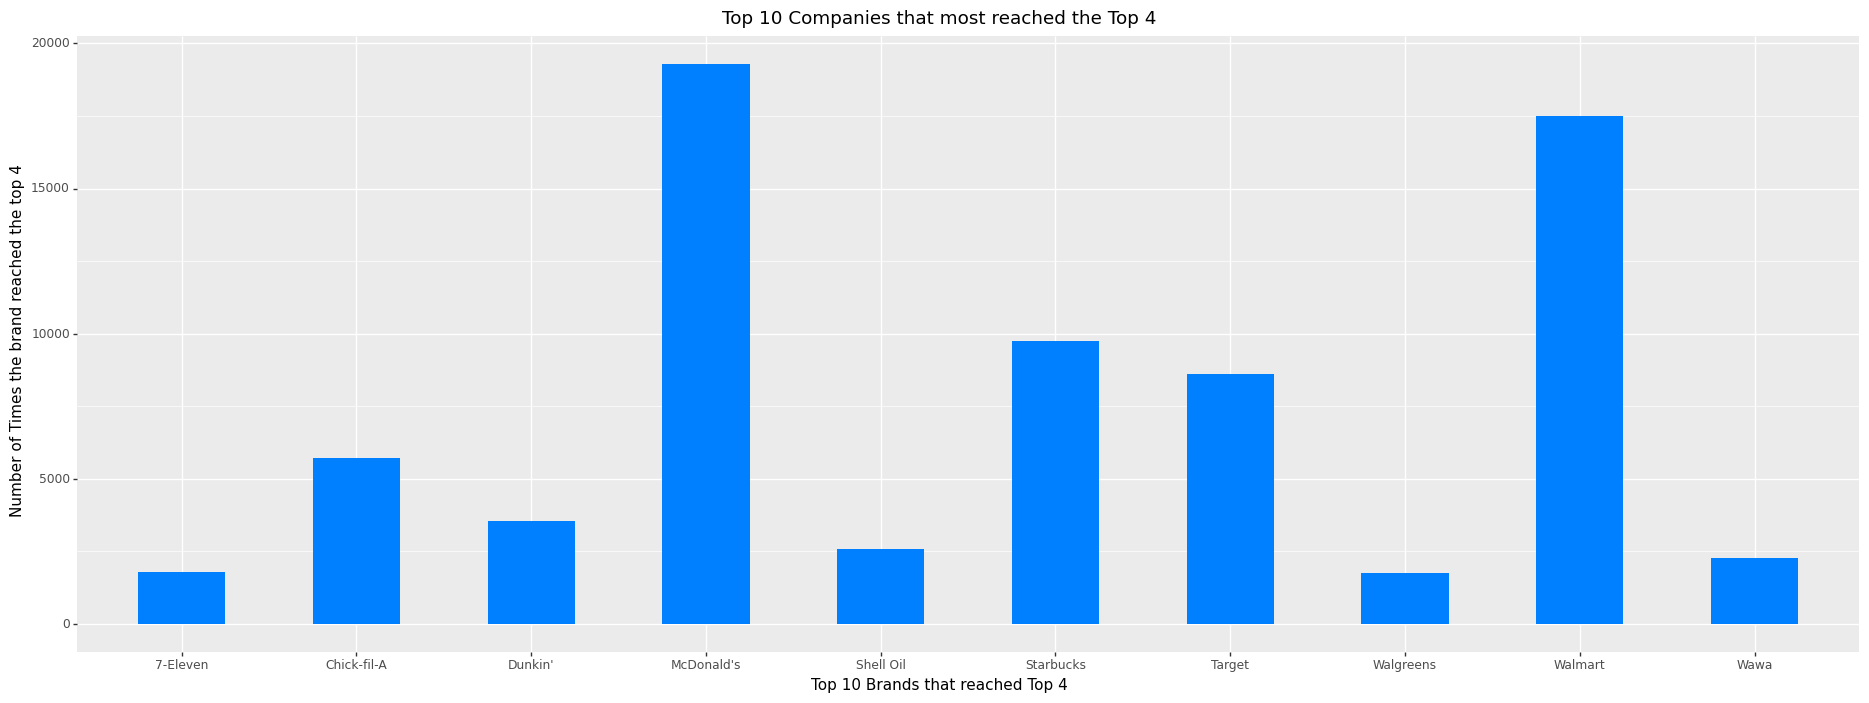

<ggplot: (8738073725437)>

In [0]:
#Get the count value of how many times a specific company made it to the top 4, and order it by descending. Then limit the columns to display only the top 10 to get most popular brands.
top10_most_popular_same_day = day_app_dataset.groupBy('same_day_brand').count().orderBy('count' , ascending=False).withColumnRenamed("count", "same_day_numOfTimes_reached_top4").limit(10)
top10_most_popular_same_month = day_app_dataset2.groupBy('same_month_brand').count().orderBy('count' , ascending=False).withColumnRenamed("count", "month_day_numOfTimes_reached_top4").limit(10)

#Convert data to pandas to plot the charts.
top10_most_popular_same_day_table = top10_most_popular_same_day.toPandas()
top10_most_popular_same_month_table = top10_most_popular_same_month.toPandas()

display(top10_most_popular_same_day_table)

#display chart for the top 10 most visited in the same day.
(ggplot(top10_most_popular_same_day_table)
 + geom_col(aes(x='same_day_brand', y ='same_day_numOfTimes_reached_top4'), width = 0.50, fill = '#0080ff')
 + theme(figure_size=(23, 8))
 + labs(x='Top 10 Brands that reached Top 4', y='Number of Times the brand reached the top 4', title="Top 10 Companies that most reached the Top 4")
)

The chart above shows us the dominance of these companies in the United States. They are the most visited brands and they usually will be the favorite place to go if you visit Chipotle. This information is crusial to understand consumer behavior of Chipotle customer and their favorite places to go when they visited Chipotle the same day.

same_month_brand month_day_numOfTimes_reached_top4 McDonald's 26379 Walmart 21784 Starbucks 10007 Chick-fil-A 8517 Target 8350 Dunkin' 4383 Walgreens 3358 Shell Oil 3140 Publix Super Markets 2800 Kroger 1930

Out[8]:

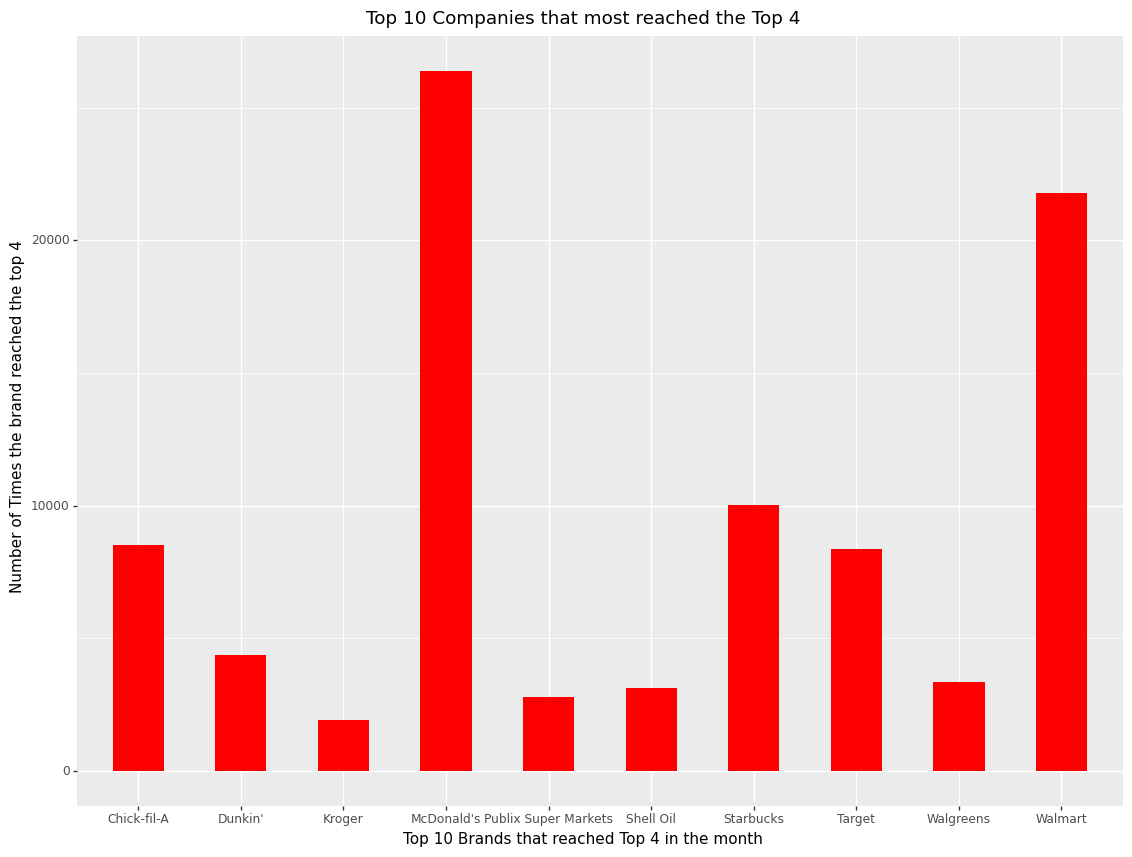

<ggplot: (8738073286909)>

In [0]:
display(top10_most_popular_same_month_table)

#display chart for the top 10 most visited in the same month.
(ggplot(top10_most_popular_same_month_table)
 + geom_col(aes(x ='same_month_brand', y ='month_day_numOfTimes_reached_top4'), width = 0.50, fill = 'red')
 + theme(figure_size=(13.5, 10))
 + labs(x='Top 10 Brands that reached Top 4 in the month', y='Number of Times the brand reached the top 4', title="Top 10 Companies that most reached the Top 4")
)

In [0]:
#Retrieving the latitude and longitude of top 10 brands in both same_day and same_month. I will use this information to plot the spatial maps.

lat_long_same_day_topBrands = day_app_dataset.filter((day_app_dataset.same_day_brand == "McDonald's") | (day_app_dataset.same_day_brand == "Walmart") | (day_app_dataset.same_day_brand == "Starbucks") | (day_app_dataset.same_day_brand == "Target") | (day_app_dataset.same_day_brand == "Chick-fil-A") | (day_app_dataset.same_day_brand == "Dunkin'") | (day_app_dataset.same_day_brand == "Shell Oil") | (day_app_dataset.same_day_brand == "Wawa") | (day_app_dataset.same_day_brand == "7-Eleven") | (day_app_dataset.same_day_brand == "Walgreens"))

lat_long_month_topBrands = day_app_dataset2.filter((day_app_dataset2.same_month_brand == "McDonald's") | (day_app_dataset2.same_month_brand == "Walmart") | (day_app_dataset2.same_month_brand == "Starbucks") | (day_app_dataset2.same_month_brand == "Target") | (day_app_dataset2.same_month_brand == "Chick-fil-A") | (day_app_dataset2.same_month_brand == "Dunkin'") | (day_app_dataset2.same_month_brand == "Shell Oil") | (day_app_dataset2.same_month_brand == "Publix Super Markets") | (day_app_dataset2.same_month_brand == "Kroger") | (day_app_dataset2.same_month_brand == "Walgreens"))

display(lat_long_same_day_topBrands)
display(lat_long_month_topBrands)

latitude longitude same_day_top_rank same_day_brand day_%_value 26.172008 -81.800831 1 McDonald's 7 26.172008 -81.800831 2 Shell Oil 7 26.172008 -81.800831 3 Walgreens 5 26.172008 -81.800831 4 Walmart 5 30.08864 -95.521543 1 Target 8 30.08864 -95.521543 2 Chick-fil-A 7 30.08864 -95.521543 4 Walmart 5 38.899964 -76.791647 2 McDonald's 10 41.368865 -72.918355 1 Walmart 8 41.368865 -72.918355 2 Dunkin' 7 41.368865 -72.918355 3 McDonald's 6 41.850685 -87.802817 1 McDonald's 9 41.850685 -87.802817 3 Shell Oil 6 41.850685 -87.802817 4 Walgreens 5 41.850685 -87.802817 1 McDonald's 8 41.850685 -87.802817 2 Starbucks 5 41.850685 -87.802817 3 Target 5 41.548496 -83.600682 1 McDonald's 12 41.548496 -83.600682 4 Chick-fil-A 6 42.719633 -87.849246 1 McDonald's 9 40.687129 -74.315764 1 Dunkin' 7 40.687129 -74.315764 2 Walmart 5 40.687129 -74.315764 3 Chick-fil-A 5 40.687129 -74.315764 4 Target 4 39.281382 -76.579907 4 Target 3 38.897715 -77.006886 3 Dunkin' 10 42.104761 -87.814236 1 Target 10 42.104761 -87.814236 2 Starbucks 7 42.104761 -87.814236 3 Dunkin' 6 28.003619 -81.717527 1 Walmart 13 28.003619 -81.717527 2 McDonald's 10 28.003619 -81.717527 3 Chick-fil-A 6 45.532968 -122.935123 1 Starbucks 8 45.532968 -122.935123 3 McDonald's 5 38.798516 -97.612166 1 Walmart 14 38.798516 -97.612166 3 Target 6 28.095835 -81.974729 1 Chick-fil-A 9 28.095835 -81.974729 2 Walmart 9 28.095835 -81.974729 3 McDonald's 8 28.095835 -81.974729 4 Wawa 5 45.43777 -122.829271 1 Starbucks 7 45.43777 -122.829271 2 Walmart 6 42.16716 -87.844253 1 Starbucks 10 42.16716 -87.844253 2 McDonald's 6 26.838781 -80.10891 2 Starbucks 3 26.838781 -80.10891 3 Shell Oil 3 26.838781 -80.10891 4 7-Eleven 3 40.741741 -73.993372 1 Dunkin' 6 40.741741 -73.993372 2 Starbucks 4 40.741741 -73.993372 3 McDonald's 3 27.960161 -82.505023 1 Walmart 11 27.960161 -82.505023 2 McDonald's 6 27.960161 -82.505023 3 Wawa 5 27.960161 -82.505023 4 Shell Oil 4 41.148133 -81.507612 1 Walmart 4 41.148133 -81.507612 3 McDonald's 4 41.720002 -87.776479 1 Walgreens 8 41.720002 -87.776479 2 McDonald's 8 41.720002 -87.776479 4 Starbucks 5 40.632769 -74.305092 4 7-Eleven 5 40.906878 -74.553278 2 Target 11 40.906878 -74.553278 4 Walmart 8 35.586707 -82.58743 2 McDonald's 6 35.586707 -82.58743 4 Starbucks 4 41.66228 -81.240635 1 McDonald's 7 41.66228 -81.240635 2 Walmart 5 41.66228 -81.240635 3 Starbucks 3 42.26449 -88.980621 1 Walmart 7 42.26449 -88.980621 2 McDonald's 5 42.26449 -88.980621 3 Target 5 28.078442 -80.647515 1 Walmart 9 28.078442 -80.647515 2 McDonald's 9 28.078442 -80.647515 3 Wawa 8 28.078442 -80.647515 4 7-Eleven 5 36.126472 -97.053388 1 Walmart 14 36.126472 -97.053388 2 Chick-fil-A 7 25.589608 -80.358702 1 McDonald's 6 25.589608 -80.358702 2 Walmart 5 25.589608 -80.358702 3 Starbucks 5 40.734249 -73.98883 1 Starbucks 5 40.734249 -73.98883 2 Dunkin' 4 40.734249 -73.98883 3 Target 2 40.734249 -73.98883 4 McDonald's 2 38.770636 -77.082257 1 McDonald's 10 38.770636 -77.082257 2 Walmart 9 38.770636 -77.082257 3 7-Eleven 8 38.770636 -77.082257 4 Shell Oil 6 26.934231 -80.130647 1 Walmart 5 26.934231 -80.130647 2 McDonald's 4 26.934231 -80.130647 3 Starbucks 4 25.769278 -80.359828 2 Walmart 5 25.769278 -80.359828 3 McDonald's 5 39.562076 -76.971639 1 Wawa 9 39.562076 -76.971639 2 Chick-fil-A 8 39.562076 -76.971639 3 McDonald's 8 40.739225 -96.679444 2 Walmart 5 40.739225 -96.679444 4 McDonald's 4 27.037403 -82.21618 1 Walmart 19 27.037403 -82.21618 3 McDonald's 6 27.037403 -82.21618 4 Starbucks 5 27.037403 -82.21618 2 Walmart 11 38.923724 -77.052 1 McDonald's 14 33.855531 -84.5993 2 Walmart 15 33.855531 -84.5993 3 McDonald's 13 27.387623 -82.458131 1 Target 16 27.387623 -82.458131 4 Starbucks 6 39.360216 -84.460196 2 McDonald's 11 39.360216 -84.460196 4 Walmart 3 41.628867 -93.697242 2 Walmart 9 41.628867 -93.697242 3 McDonald's 8 41.628867 -93.697242 4 Target 5 39.412702 -76.772287 1 McDonald's 15 39.412702 -76.772287 2 Chick-fil-A 13 39.412702 -76.772287 3 Walmart 10 41.885576 -87.635232 1 Dun

latitude longitude same_month_top_rank same_month_brand month_%_value 26.172008 -81.800831 1 Walmart 49 26.172008 -81.800831 2 McDonald's 46 26.172008 -81.800831 3 Shell Oil 40 30.08864 -95.521543 1 Chick-fil-A 69 30.08864 -95.521543 2 Walmart 62 38.899964 -76.791647 1 McDonald's 71 38.899964 -76.791647 2 Walmart 51 38.899964 -76.791647 3 Chick-fil-A 44 41.368865 -72.918355 1 Dunkin' 57 41.368865 -72.918355 2 McDonald's 53 41.368865 -72.918355 3 Walmart 45 41.850685 -87.802817 1 McDonald's 65 41.850685 -87.802817 2 Walmart 53 41.850685 -87.802817 3 Walgreens 46 41.850685 -87.802817 4 Target 43 41.850685 -87.802817 1 McDonald's 56 41.850685 -87.802817 2 Walmart 44 41.850685 -87.802817 3 Walgreens 42 41.850685 -87.802817 4 Target 41 40.764625 -73.306642 2 McDonald's 50 40.764625 -73.306642 3 Target 47 40.764625 -73.306642 4 Starbucks 44 41.548496 -83.600682 1 McDonald's 69 41.548496 -83.600682 2 Walmart 51 41.548496 -83.600682 3 Chick-fil-A 45 42.719633 -87.849246 1 McDonald's 62 42.719633 -87.849246 3 Walgreens 55 42.719633 -87.849246 4 Walmart 53 40.687129 -74.315764 1 Dunkin' 45 40.687129 -74.315764 3 Target 35 40.687129 -74.315764 4 McDonald's 35 39.281382 -76.579907 1 McDonald's 43 39.281382 -76.579907 3 Walmart 33 39.281382 -76.579907 4 Chick-fil-A 31 38.897715 -77.006886 1 Walmart 35 42.104761 -87.814236 1 Starbucks 77 42.104761 -87.814236 2 Target 60 42.104761 -87.814236 3 McDonald's 60 42.104761 -87.814236 4 Walgreens 50 28.003619 -81.717527 1 Walmart 69 28.003619 -81.717527 2 McDonald's 65 28.003619 -81.717527 3 Chick-fil-A 43 28.003619 -81.717527 4 Publix Super Markets 42 45.532968 -122.935123 1 Starbucks 52 45.532968 -122.935123 2 McDonald's 44 45.532968 -122.935123 4 Target 34 38.798516 -97.612166 1 Walmart 66 38.798516 -97.612166 2 McDonald's 47 28.095835 -81.974729 1 Walmart 64 28.095835 -81.974729 2 McDonald's 58 28.095835 -81.974729 3 Chick-fil-A 53 28.095835 -81.974729 4 Publix Super Markets 41 45.43777 -122.829271 1 Starbucks 58 45.43777 -122.829271 2 Walmart 50 45.43777 -122.829271 3 McDonald's 49 42.16716 -87.844253 1 Starbucks 62 42.16716 -87.844253 3 McDonald's 50 26.838781 -80.10891 1 Publix Super Markets 46 26.838781 -80.10891 2 McDonald's 40 26.838781 -80.10891 3 Starbucks 39 26.838781 -80.10891 4 Chick-fil-A 33 40.741741 -73.993372 1 Starbucks 36 40.741741 -73.993372 2 Dunkin' 36 27.960161 -82.505023 1 Walmart 65 27.960161 -82.505023 2 McDonald's 52 27.960161 -82.505023 3 Starbucks 36 41.148133 -81.507612 1 McDonald's 50 41.148133 -81.507612 2 Walmart 41 41.148133 -81.507612 3 Starbucks 38 41.720002 -87.776479 1 McDonald's 59 41.720002 -87.776479 2 Walgreens 54 41.720002 -87.776479 3 Walmart 53 41.720002 -87.776479 4 Target 48 40.632769 -74.305092 1 Dunkin' 67 40.632769 -74.305092 2 Walmart 42 40.632769 -74.305092 4 McDonald's 40 40.906878 -74.553278 2 Walmart 54 40.906878 -74.553278 3 Dunkin' 50 40.906878 -74.553278 4 Target 41 35.586707 -82.58743 1 McDonald's 52 35.586707 -82.58743 2 Shell Oil 49 35.586707 -82.58743 3 Walmart 48 41.66228 -81.240635 1 McDonald's 56 41.66228 -81.240635 2 Walmart 49 41.66228 -81.240635 3 Chick-fil-A 39 42.26449 -88.980621 1 McDonald's 60 42.26449 -88.980621 2 Walmart 56 42.26449 -88.980621 3 Target 37 28.078442 -80.647515 1 Walmart 69 28.078442 -80.647515 2 McDonald's 62 36.126472 -97.053388 1 Walmart 83 36.126472 -97.053388 2 Chick-fil-A 51 36.126472 -97.053388 3 McDonald's 51 25.589608 -80.358702 1 McDonald's 62 25.589608 -80.358702 2 Shell Oil 48 25.589608 -80.358702 3 Starbucks 42 25.589608 -80.358702 4 Walmart 42 40.734249 -73.98883 1 Starbucks 36 40.734249 -73.98883 2 McDonald's 32 40.734249 -73.98883 3 Dunkin' 31 38.770636 -77.082257 1 McDonald's 64 38.770636 -77.082257 2 Walmart 59 38.770636 -77.082257 4 Target 40 26.934231 -80.130647 1 Walmart 47 26.934231 -80.130647 2 McDonald's 45 26.934231 -80.130647 3 Publix Super Markets 43 26.934231 -80.130647 4 Starbucks 39 25.769278 -80.359828 1 McDonald's 48 25.769278 -80.359828 2 Walmart 43 25.769278 -80.359828 4 Publ